In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.linalg as la
import numpy.linalg as npla
from scipy.stats import ortho_group

from gpid.estimate import approx_pid_from_cov
from gpid.tilde_pid import exact_gauss_tilde_pid

In [3]:
# Choose which PID definition to use here
pid_defn = exact_gauss_tilde_pid
# pid_defn = exact_pid_pytorch
# pid_defn = approx_pid_from_cov

In [4]:
# General utilities
def rotn_mat_2d(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])


def move_cov_block_to_end(cov, i, j):
    """
    Moves the variables indexed by i:j to the end of the covariance matrix.
    Assumes the covariance matrix is symmetric.
    Negative indices will not work.
    """
    if i >= j:
        raise ValueError('Index i must be less than index j')
    cov_new = np.delete(cov, np.s_[i:j], axis=0)
    cov_new = np.delete(cov_new, np.s_[i:j], axis=1)
    diag_block = cov[i:j, i:j]
    nondiag_block = np.delete(cov[i:j, :], np.s_[i:j], axis=1)
    return np.block([[cov_new, nondiag_block.T], [nondiag_block, diag_block]])


def switch_x_and_y(cov, dm, dx, dy):
    # XXX: Can now be replaced by the function above: simply move the X block to the end
    cov2 = np.zeros(cov.shape)
    cov2[:dm, :dm] = cov[:dm, :dm]                 # 1, 1 = 1, 1
    cov2[dm:dm+dy, :dm] = cov[dm+dx:, :dm]         # 2, 1 = 3, 1
    cov2[dm+dy:, :dm] = cov[dm:dm+dx, :dm]         # 3, 1 = 2, 1
    cov2[dm+dy:, dm:dm+dy] = cov[dm:dm+dx, dm+dx:] # 3, 2 = 2, 3
    cov2[dm:dm+dy, dm:dm+dy] = cov[dm+dx:, dm+dx:] # 2, 2 = 3, 3
    cov2[dm+dy:, dm+dy:] = cov[dm:dm+dx, dm:dm+dx] # 3, 3 = 2, 2
    cov2[np.triu_indices(cov2.shape[0], k=1)] = 0
    cov2 += cov2.T
    cov2[np.diag_indices(cov2.shape[0])] = cov2[np.diag_indices(cov2.shape[0])] / 2
    return cov2, dm, dy, dx


def random_rotation_mxy(cov, dm, dx, dy):
    """
    Perform random rotations on the M, X and Y components of a covariance matrix.
    Returns a copy.
    """
    cov = cov.copy()
    
    R = ortho_group.rvs(dm)
    cov[:dm, :] = R @ cov[:dm, :]
    cov[:, :dm] = cov[:, :dm] @ R.T
    R = ortho_group.rvs(dx)
    cov[dm:dm+dx, :] = R @ cov[dm:dm+dx, :]
    cov[:, dm:dm+dx] = cov[:, dm:dm+dx] @ R.T
    R = ortho_group.rvs(dy)
    cov[dm+dx:, :] = R @ cov[dm+dx:, :]
    cov[:, dm+dx:] = cov[:, dm+dx:] @ R.T

    return cov


def merge_covs(cov1, cov2, dm1, dx1, dy1, dm2=None, dx2=None, dy2=None, random_rotn=False):
    """
    Merges two covariance matrices of given M, X and Y dimensions.
    Performs a random rotation on M, X and Y after merging, if random_rotn is True.
    """
    if dm2 is None:
        dm2 = dm1
    if dx2 is None:
        dx2 = dx1
    if dy2 is None:
        dy2 = dy1
    
    dm = dm1 + dm2
    dx = dx1 + dx2
    dy = dy1 + dy2

    zero_block = np.zeros((cov1.shape[0], cov2.shape[0]))
    cov = np.block([[cov1, zero_block], [zero_block.T, cov2]])
    
    # Move required blocks to end: order of ops is important!
    cov = move_cov_block_to_end(cov, dm1, dm1 + dx1 + dy1)
    # Diag now reads: M1, M2, X2, Y2, X1, Y1
    cov = move_cov_block_to_end(cov, dm, dm + dx2)
    # Diag now reads: M1, M2, Y2, X1, Y1, X2
    cov = move_cov_block_to_end(cov, dm + dy2 + dx1, dm + dy2 + dx1 + dy1)
    # Diag now reads: M1, M2, Y2, X1, X2, Y1
    cov = move_cov_block_to_end(cov, dm, dm + dy2)
    # Diag now reads: M1, M2, X1, X2, Y1, Y2
    
    if random_rotn:
        cov = random_rotation_mxy(cov, dm, dx, dy)
    
    return cov, dm, dx, dy

root2 = np.sqrt(2)
root3 = np.sqrt(3)

In [14]:
def print_pid_vals(pid_vals):
    print(pd.DataFrame(pid_vals.reshape(1, -1), columns=['I(M; X,Y)', 'UI_X', 'UI_Y', 'RI', 'SI']).iloc[0])

    
def compute_and_print(pid_defn, cov, dm, dx, dy, plot=True):
    ret_approx = pid_defn(cov, dm, dx, dy, ret_t_sigt=True, plot=True)
    approx_gt_pid = np.r_[ret_approx[2], ret_approx[5:9]]
    print(ret_approx[12]) # Optimal sigxy
    print_pid_vals(approx_gt_pid)
    plt.show()

#### Both unique: Sampling orthogonal directions
Expect to see UI_X = UI_Y = 0.5 bits; RI = SI = 0

<IPython.core.display.Javascript object>


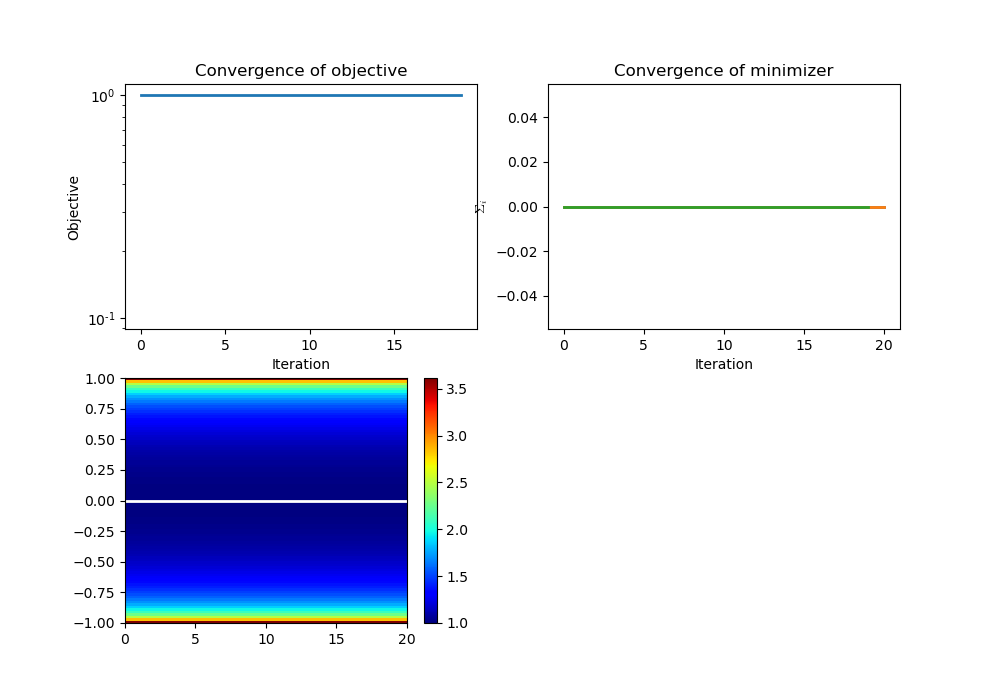

[[0.]]
I(M; X,Y)    9.999999e-01
UI_X         5.000000e-01
UI_Y         5.000000e-01
RI           3.606737e-08
SI          -3.606737e-08
Name: 0, dtype: float64


In [6]:
dm, dx, dy = 2, 1, 1

sigm = np.eye(dm)
hx = np.array([[1, 0]])
hy = np.array([[0, 1]])
sigx_m = np.eye(dx)
sigy_m = np.eye(dy)
sigw = np.zeros((dx, dy))

cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                [hx @ sigm, hx @ sigm @ hx.T + sigx_m, hx @ sigm @ hy.T + sigw],
                [hy @ sigm, hy @ sigm @ hx.T + sigw.T, hy @ sigm @ hy.T + sigy_m]])

compute_and_print(pid_defn, cov, dm, dx, dy)

#### Sampling the same direction, with different gain and independent noise

Expect to see I(M ; X,Y) = 1bit, UI_X = 0.29, UI_Y = 0 bits, RI = 0.5 bits, SI = (leftover)

0.29248125036057804


<IPython.core.display.Javascript object>


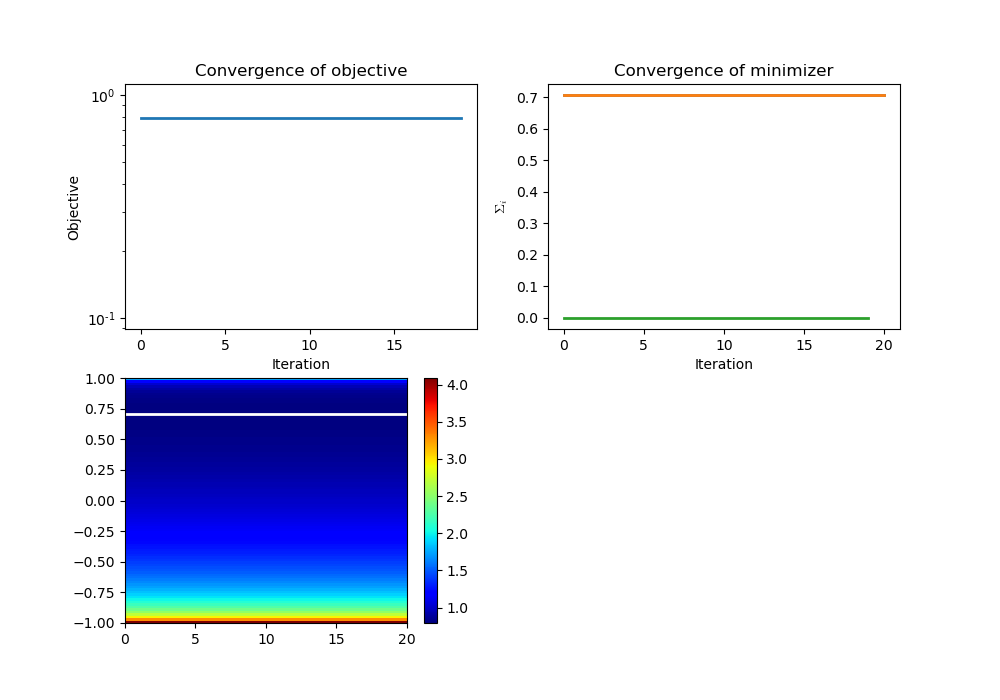

[[0.70710678]]
I(M; X,Y)    1.000000
UI_X         0.000000
UI_Y         0.292481
RI           0.500000
SI           0.207519
Name: 0, dtype: float64


In [7]:
dm, dx, dy = 2, 1, 1

sigm = np.eye(dm)
hx = np.array([[root2, 0]])
hy = np.array([[1, 0]])
sigx_m = np.eye(dx)
sigy_m = np.eye(dy)
sigw = np.zeros((dx, dy))

cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                [hx @ sigm, hx @ sigm @ hx.T + sigx_m, hx @ sigm @ hy.T + sigw],
                [hy @ sigm, hy @ sigm @ hx.T + sigw.T, hy @ sigm @ hy.T + sigy_m]])

cov, dm, dx, dy = switch_x_and_y(cov, dm, dx, dy)

print(0.5 * np.log2(3) - 0.5)
compute_and_print(pid_defn, cov, dm, dx, dy)

#### Sampling the same direction with fully dependent noise

Expect to see UI_X = 0.29, UI_Y = 0 bits, RI = 0.5 bits, SI = 0

<IPython.core.display.Javascript object>


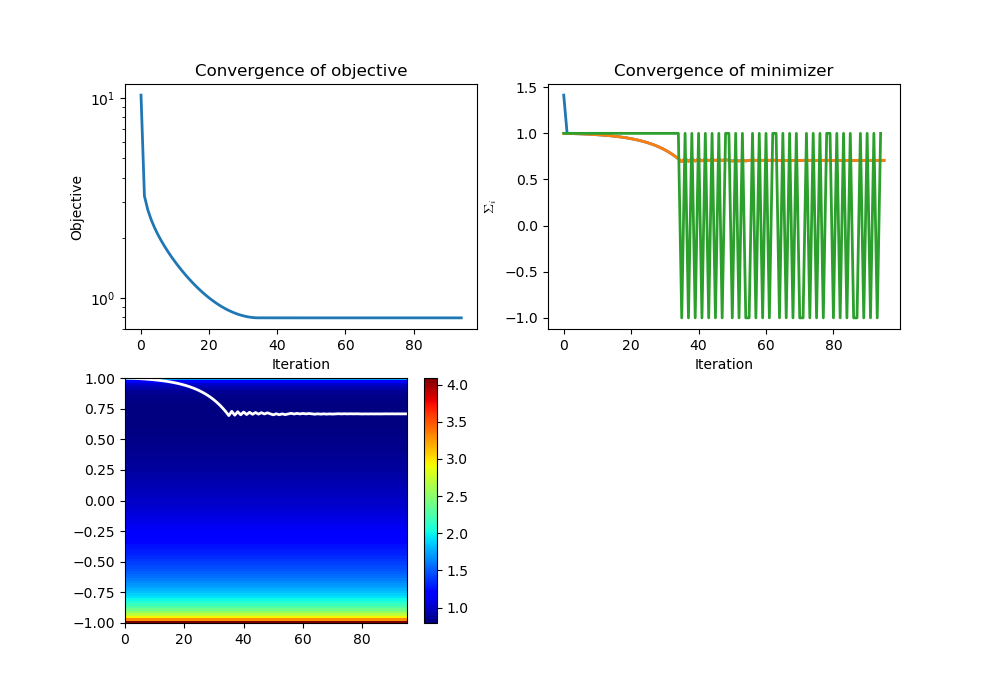

[[0.70710247]]
I(M; X,Y)    7.924812e-01
UI_X         2.924812e-01
UI_Y        -4.807134e-08
RI           5.000000e-01
SI          -1.849088e-11
Name: 0, dtype: float64


In [8]:
dm, dx, dy = 2, 1, 1

sigm = np.eye(dm)
hx = np.array([[root2, 0],])
hyx = np.array([[1]])
hy = hyx @ hx
sigx_m = 1 * np.eye(dx)
sigy_x = 1 * np.eye(dx)
covx = hx @ sigm @ hx.T + sigx_m
cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                [hx @ sigm, covx, covx @ hyx.T],
                [hy @ sigm, hyx @ covx, hyx @ covx @ hyx.T + sigy_x]])

# cov, dm, dx, dy = switch_x_and_y(cov, dm, dx, dy)

compute_and_print(pid_defn, cov, dm, dx, dy)

#### Composition: X samples two directions of M equally, Y samples one, with the same SNR as X
Expect to see: UI_X = 0.5, UI_Y = 0, RI = 0.5, SI = (leftover) = 0.29

<IPython.core.display.Javascript object>


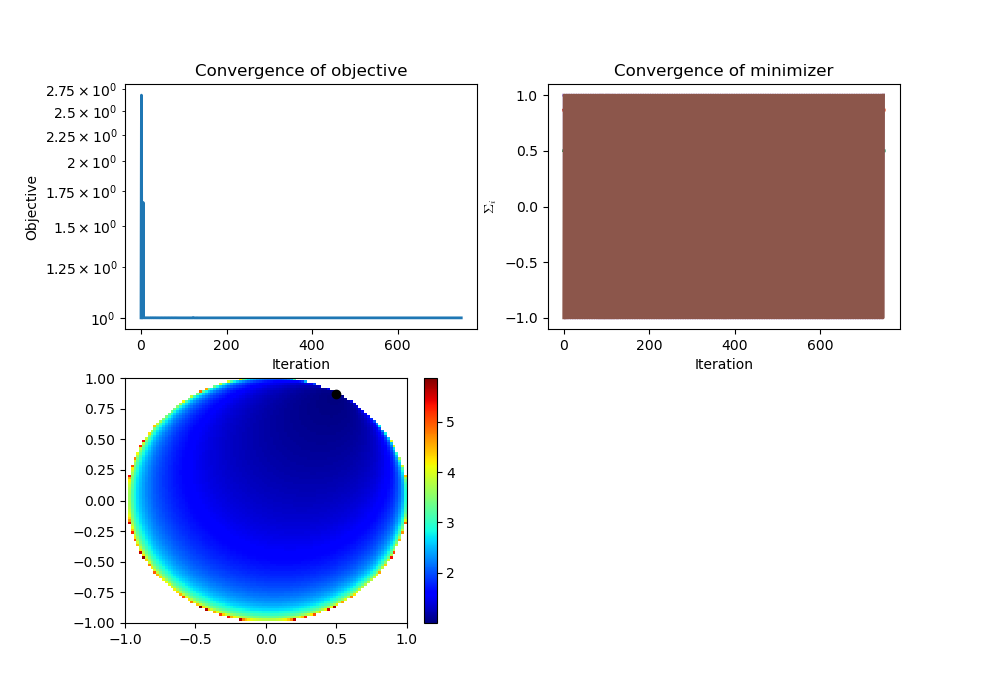

[[0.5      ]
 [0.8660254]]
I(M; X,Y)    1.292481e+00
UI_X         5.000000e-01
UI_Y        -3.606737e-08
RI           5.000000e-01
SI           2.924812e-01
Name: 0, dtype: float64


In [9]:
dm, dx, dy = 2, 2, 1

# Both unique 2x2
sigm = np.eye(dm)
hx = np.array([[1, 0], [0, 1]]) @ rotn_mat_2d(-30 * np.pi / 180)
hy = np.array([[0, 1]])
sigx_m = np.eye(dx)
sigy_m = np.eye(dy)
sigw = np.zeros((dx, dy))

# Covariance matrix construction for both unique or redundant
cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                [hx @ sigm, hx @ sigm @ hx.T + sigx_m, hx @ sigm @ hy.T + sigw],
                [hy @ sigm, hy @ sigm @ hx.T + sigw.T, hy @ sigm @ hy.T + sigy_m]])

# cov, dm, dx, dy = switch_x_and_y(cov, dm, dx, dy)

compute_and_print(pid_defn, cov, dm, dx, dy)

<IPython.core.display.Javascript object>


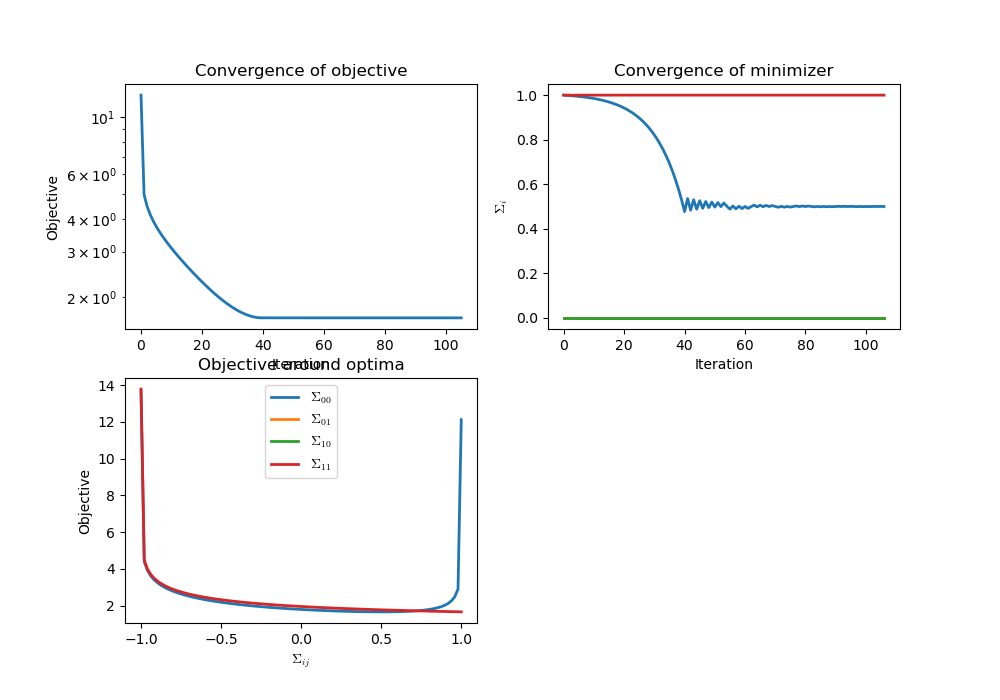

[[0.50000516 0.        ]
 [0.         1.        ]]
I(M; X,Y)    2.084962e+00
UI_X         6.609640e-01
UI_Y        -5.768767e-08
RI           1.000000e+00
SI           4.239984e-01
Name: 0, dtype: float64


In [10]:
# Testing what's going on in the 2x2 cases below

dm, dx, dy = 2, 2, 2

# theta = np.linspace(0, np.pi/2, 1000)[1]
# theta = np.logspace(-5, np.log10(np.pi/2), 10)[4]
# hx = np.array([[root2, 0], [0, 1]]) @ rotn_mat_2d(-theta)
# hy = np.array([[1, 0], [0, root2]])

gain = np.linspace(0, 3, 10)[6]
hx = np.array([[gain, 0], [0, 1]])
hy = np.array([[1, 0], [0, 1]])

sigm = np.eye(dm)
sigx_m = np.eye(dx)
sigy_m = np.eye(dy)
sigw = np.zeros((dx, dy))

cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                [hx @ sigm, hx @ sigm @ hx.T + sigx_m, hx @ sigm @ hy.T + sigw],
                [hy @ sigm, hy @ sigm @ hx.T + sigw.T, hy @ sigm @ hy.T + sigy_m]])

# cov, dm, dx, dy = switch_x_and_y(cov, dm, dx, dy)

compute_and_print(pid_defn, cov, dm, dx, dy)

#### PID values as a function of fixed gain and changing angle

0 1 2 3 4 5 6 7 8 9 

<IPython.core.display.Javascript object>


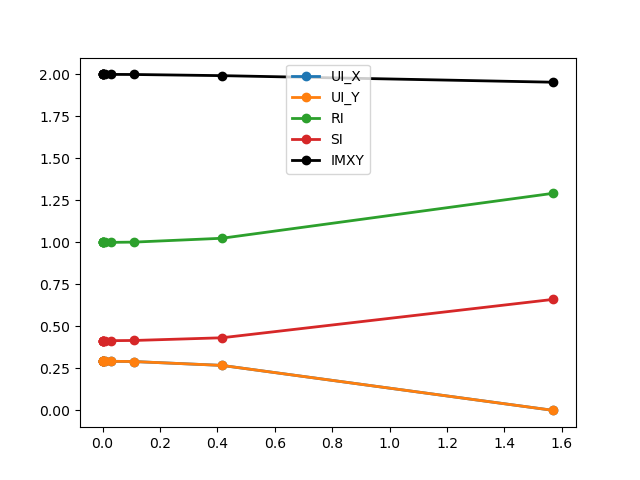

I(M; X,Y)    2.000000
UI_X         0.292481
UI_Y         0.292481
RI           1.000000
SI           0.415037
Name: 0, dtype: float64
I(M; X,Y)    1.953445
UI_X         0.000000
UI_Y         0.000000
RI           1.292481
SI           0.660964
Name: 0, dtype: float64


In [15]:
dm, dx, dy = 2, 2, 2
# thetas = np.linspace(0, np.pi/2, 10)
thetas = np.logspace(-5, np.log10(np.pi/2), 10)

pid_vals = []
for i, theta in enumerate(thetas):
    print(i, end=' ', flush=True)
    # Both unique 2x2
    sigm = np.eye(dm)
    hx = np.array([[root2, 0], [0, 1]]) @ rotn_mat_2d(-theta)
    hy = np.array([[1, 0], [0, root2]])
    sigx_m = np.eye(dx)
    sigy_m = np.eye(dy)
    sigw = np.zeros((dx, dy))

    # Covariance matrix construction for both unique or redundant
    cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                    [hx @ sigm, hx @ sigm @ hx.T + sigx_m, hx @ sigm @ hy.T + sigw],
                    [hy @ sigm, hy @ sigm @ hx.T + sigw.T, hy @ sigm @ hy.T + sigy_m]])

    # cov, dm, dx, dy = switch_x_and_y(cov, dm, dx, dy)
    
    ret = pid_defn(cov, dm, dx, dy, ret_t_sigt=False)
    imxy, uix, uiy, ri, si = ret[2], *ret[-4:]
    pid_vals.append([imxy, uix, uiy, ri, si])
    
pid_vals = np.array(pid_vals)
plt.figure()
plt.plot(thetas, pid_vals[:, 1:], '-o')
plt.plot(thetas, pid_vals[:, 0], 'k-o')
plt.legend(['UI_X', 'UI_Y', 'RI', 'SI', 'IMXY'])
plt.show()

print_pid_vals(pid_vals[0])
print_pid_vals(pid_vals[-1])

#### PID values as a function of fixed angle and changing gain (in X)

0 1 2 3 4 5 6 7 8 9 

<IPython.core.display.Javascript object>


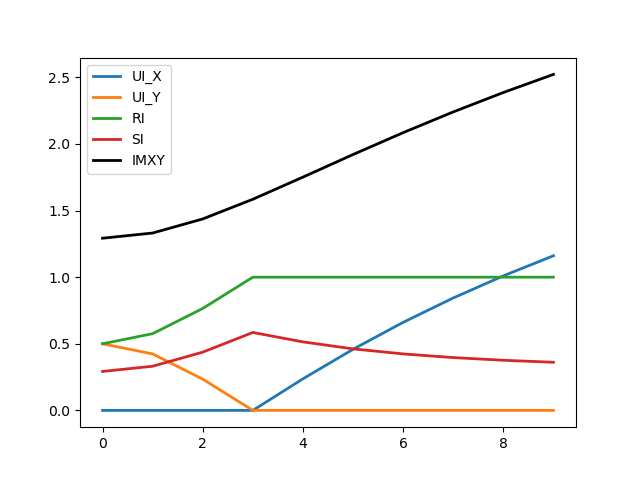

I(M; X,Y)    1.292481
UI_X         0.000000
UI_Y         0.500000
RI           0.500000
SI           0.292481
Name: 0, dtype: float64
I(M; X,Y)    1.584962
UI_X         0.000000
UI_Y         0.000000
RI           1.000000
SI           0.584962
Name: 0, dtype: float64
I(M; X,Y)    2.522197e+00
UI_X         1.160964e+00
UI_Y        -6.492057e-08
RI           1.000000e+00
SI           3.612330e-01
Name: 0, dtype: float64


In [16]:
dm, dx, dy = 2, 2, 2
gains = np.linspace(0, 3, 10)

pid_vals = []
for i, gain in enumerate(gains):
    print(i, end=' ', flush=True)
    # Both unique 2x2
    sigm = np.eye(dm)
    hx = np.array([[gain, 0], [0, 1]]) #@ rotn_mat_2d(-theta)
    hy = np.array([[1, 0], [0, 1]])
    sigx_m = np.eye(dx)
    sigy_m = np.eye(dy)
    sigw = np.zeros((dx, dy))

    # Covariance matrix construction for both unique or redundant
    cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                    [hx @ sigm, hx @ sigm @ hx.T + sigx_m, hx @ sigm @ hy.T + sigw],
                    [hy @ sigm, hy @ sigm @ hx.T + sigw.T, hy @ sigm @ hy.T + sigy_m]])

    #cov, dm, dx, dy = switch_x_and_y(cov, dm, dx, dy)

    ret = pid_defn(cov, dm, dx, dy, ret_t_sigt=False)
    imxy, uix, uiy, ri, si = ret[2], *ret[-4:]
    pid_vals.append([imxy, uix, uiy, ri, si])
    
pid_vals = np.array(pid_vals)
plt.figure()
plt.plot(pid_vals[:, 1:])
plt.plot(pid_vals[:, 0], 'k-')
plt.legend(['UI_X', 'UI_Y', 'RI', 'SI', 'IMXY'])
plt.show()

print_pid_vals(pid_vals[0])
print_pid_vals(pid_vals[3])
print_pid_vals(pid_vals[-1])

#### PID Values for covariance matrices of increasing size: fixed angle, changing gain

0: 0 1 2 3 4 
1: 0 1 2 3 4 
2: 0 1 2 3 4 
3: 0 1 2 3 4 
4: 0 1 2 3 4 
5: 0 

/home/praveen/Dropbox/Research/gpid/src/gpid/tilde_pid.py:112: UserWarning: Exceeded maximum number of iterations. May not have converged.
  warnings.warn('Exceeded maximum number of iterations. May not have converged.')


1 2 3 4 
6: 0 1 2 3 4 
7: 0 1 2 3 4 
8: 0 1 2 3 4 
9: 0 1 2 3 4 


<IPython.core.display.Javascript object>


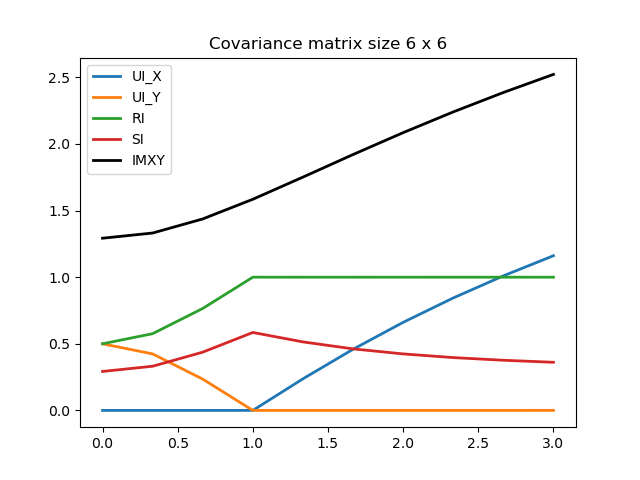

<IPython.core.display.Javascript object>


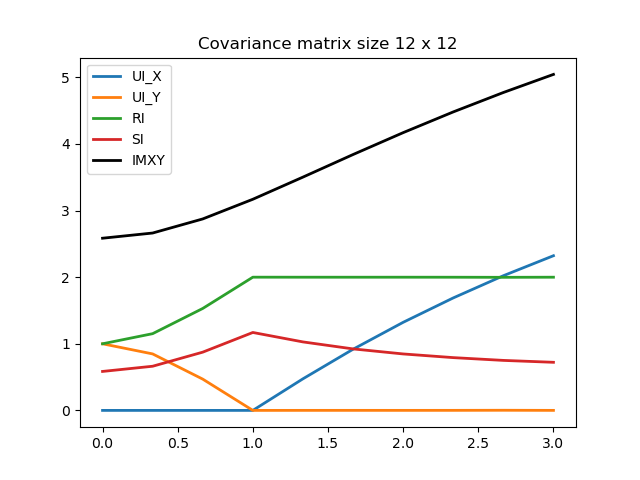

<IPython.core.display.Javascript object>


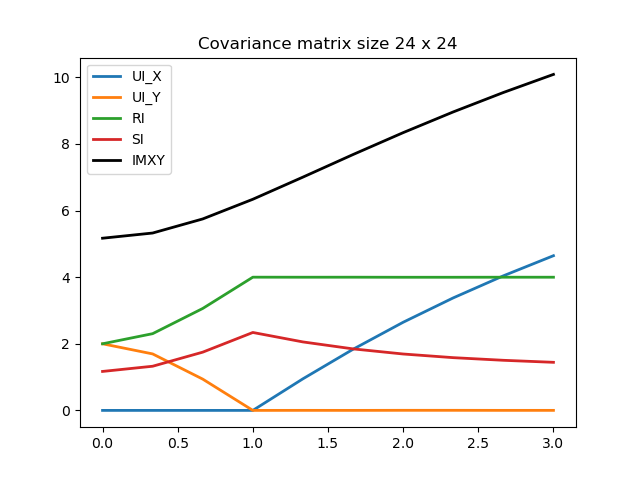

<IPython.core.display.Javascript object>


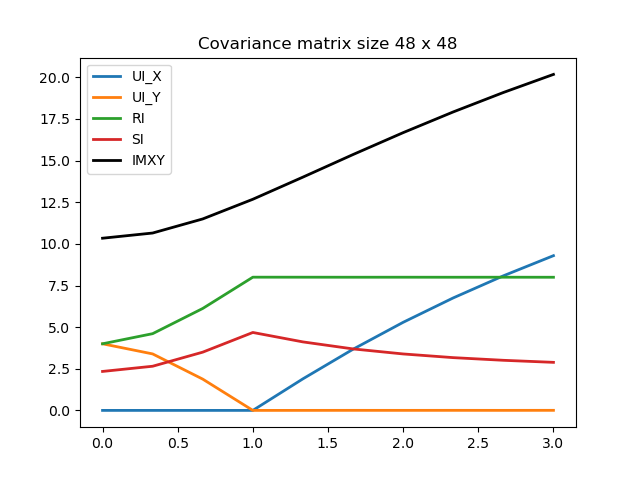

<IPython.core.display.Javascript object>


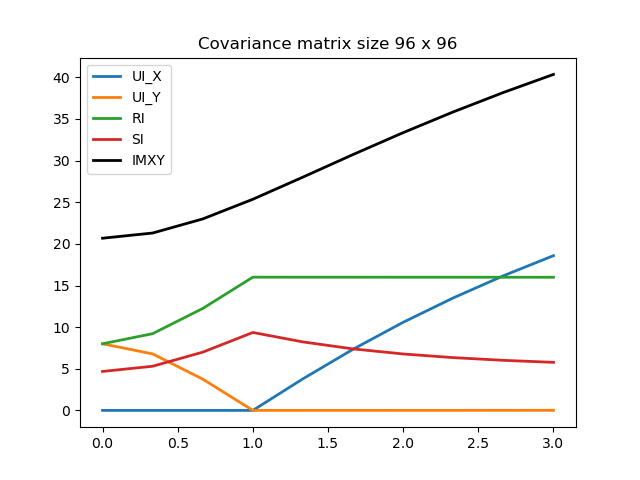

In [17]:
gains = np.linspace(0, 3, 10)
num_doubles = 5
random_rotn = True

pid_vals = []
sizes = []
covs = []

# import joblib
# covs_saved = joblib.load('bge_out2.pkl')['covs']

for i, gain in enumerate(gains):
    print(i, end=': ', flush=True)
    
    covs.append([])
    for j in range(num_doubles):
        print(j, end=' ', flush=True)
        if j == 0:
            dm, dx, dy = 2, 2, 2
            hx = np.array([[gain, 0], [0, 1]])
            hy = np.array([[1, 0], [0, 1]])
            sigm = np.eye(dm)
            sigx_m = np.eye(dx)
            sigy_m = np.eye(dy)
            sigw = np.zeros((dx, dy))
            cov = np.block([[sigm, sigm @ hx.T, sigm @ hy.T],
                            [hx @ sigm, hx @ sigm @ hx.T + sigx_m, hx @ sigm @ hy.T + sigw],
                            [hy @ sigm, hy @ sigm @ hx.T + sigw.T, hy @ sigm @ hy.T + sigy_m]])
            cov_old = cov.copy()
        else:
            cov, dm, dx, dy = merge_covs(cov_old, cov_old.copy(), dm, dx, dy)
            cov_old = cov.copy()

        if random_rotn:
            cov = random_rotation_mxy(cov, dm, dx, dy)
        
#         cov = covs_saved[i][j]
        dm = dx = dy = 2**(j+1)
        
        covs[i].append(cov.copy())

        ret1 = pid_defn(cov, dm, dx, dy, ret_t_sigt=False)
#         cov, dm, dx, dy = switch_x_and_y(cov, dm, dx, dy)
#         ret2 = pid_defn(cov, dm, dx, dy, ret_t_sigt=False)
        
#         if ret1[3] < ret2[3]:
#             imxy, uix, uiy, ri, si = ret1[2], *ret1[-4:]
#         else:
#             # Note the change in order of uiy and uix wrt to above
#             imxy, uiy, uix, ri, si = ret2[2], *ret2[-4:]

        imxy, uix, uiy, ri, si = ret1[2], *ret1[-4:]
        pid_vals.append([imxy, uix, uiy, ri, si])
        sizes.append(cov.shape[0])
        
    print()
    
pid_vals = np.array(pid_vals).reshape((-1, num_doubles, 5))

for j in range(num_doubles):
    plt.figure()
    plt.plot(gains, pid_vals[:, j, 1:])
    plt.plot(gains, pid_vals[:, j, 0], 'k-')
    plt.legend(['UI_X', 'UI_Y', 'RI', 'SI', 'IMXY'])
    plt.title('Covariance matrix size %d x %d' % (sizes[j], sizes[j]))
    plt.show()

In [ ]:
# import joblib
# joblib.dump({'covs': covs, 'pid_vals': pid_vals}, 'bge_out3.pkl')